In [2]:
import sys

In [1]:
sys.path.insert(1,'../../')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import genhelper.vcf_helper as vhelper
from sklearn.metrics import r2_score
import zarr

In [4]:
vcfpath = './raw/chr22.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)

--- 439.49593329429626 seconds ---


In [5]:
raw_callset = zarr.open_group(zarr_path)

In [6]:
raw_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [7]:
vcfpath = './interim/G1K_chr22_biallelic.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
biallelic_callset = zarr.open_group(zarr_path)

--- 437.8507101535797 seconds ---


In [8]:
biallelic_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [16]:
np.unique(biallelic_callset.variants.POS[:]).shape,biallelic_callset.variants.POS.shape

((1055453,), (1055454,))

In [17]:
vcfpath = './test/chr22_predict.dose.vcf'
zarr_path = vhelper.get_zarr_path(vcfpath)
predict_callset = zarr.open_group(zarr_path)

In [18]:
predict_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [20]:
predict_callset.variants.POS.shape

(1097199,)

In [32]:
zarr_gtruth_path = vhelper.get_zarr_path('./test/chr22_gtruth.recode.vcf')

In [33]:
gtruth_callset = zarr.open_group(zarr_gtruth_path)

In [34]:
gtruth_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [69]:
def maf_cal(x):
    return x if x < 0.5 else 1-x
xindex_col = 'PINDEX'
poss_name = 'POS'
alt_name = 'ALT'
af_name = 'AF'
predict_data = pd.DataFrame({
    poss_name : predict_callset.variants.POS[:],
    alt_name : predict_callset.variants.ALT[:,0],
    xindex_col : np.arange(predict_callset.variants.POS.size,dtype=int)
})
yindex_col = 'GINDEX'
gtruth_data = pd.DataFrame({
    poss_name : gtruth_callset.variants.POS[:],
    alt_name : gtruth_callset.variants.ALT[:,0],
    yindex_col : np.arange(gtruth_callset.variants.POS.size,dtype=int),
    af_name : gtruth_callset.variants.AF[:,0]
})
panel_data = pd.DataFrame({
    poss_name : callset.variants.POS[:],
    alt_name : callset.variants.ALT[:,0],
    af_name : callset.variants.AF[:,0]
})
gtruth_data['AF'] = gtruth_data['AF'].apply(maf_cal)
gtruth_data.rename(columns={'AF': 'MAF'},inplace=True)

In [70]:
gtruth_data.merge(panel_data, on=['POS','ALT'], how='inner', indicator=True)

,POS,ALT,GINDEX,MAF,AF,_merge
0,16050075,G,0,0.000200,0.000200,both
1,16050115,A,1,0.006390,0.006390,both
2,16050213,T,2,0.007588,0.007588,both
3,16050319,T,3,0.000200,0.000200,both
4,16050527,A,4,0.000200,0.000200,both
...,...,...,...,...,...,...
1069813,51241342,A,1071945,0.000200,0.000200,both
1069814,51241386,G,1071946,0.013978,0.013978,both
1069815,51244163,G,1071947,0.007788,0.007788,both
1069816,51244205,T,1071948,0.000200,0.000200,both


In [19]:
predict_data.shape, gtruth_data.shape

((1097199, 3), (1071950, 4))

In [60]:
# Lấy ra dữ liệu và cho biết dữ liệu đó tồn tại ở cùng hay 1 bên của bảng
g_p_data = gtruth_data.merge(predict_data, on=['POS','ALT'], how='inner', indicator=True)
bins = np.arange(0.51,step=0.02)
labels = bins[1:]
bin_name = 'bin'
g_p_data[bin_name] = pd.cut(g_p_data['MAF'],bins=bins,labels=labels)

In [61]:
def r2_score_by_bin(labels,bin_name,df,xindex_col,yindex_col,xgt,ygt):
    r2_scores = []
    for label in labels:
        temp = df[df[bin_name] == label]
        xindexs = temp[xindex_col].values
        yindexs = temp[yindex_col].values
        r2_ = r2_score(ygt[yindexs],xgt[xindexs])
        r2_scores.append(r2_)
    return r2_scores

In [62]:
xgt = predict_callset.calldata.GT[:]
xgt = xgt.reshape((xgt.shape[0],xgt.shape[1]*2))
ygt = gtruth_callset.calldata.GT[:]
ygt = ygt.reshape((ygt.shape[0],ygt.shape[1]*2))
r2_maf = r2_score_by_bin(labels,bin_name,g_p_data,xindex_col,yindex_col,xgt,ygt)

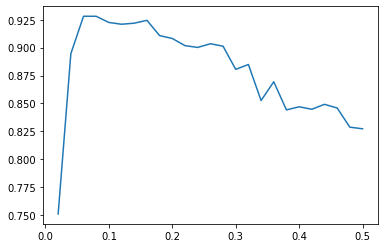

In [63]:
plt.plot(labels,r2_maf)